In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from collections import defaultdict
import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [2]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*" -s

In [3]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [4]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2
# plt.rcParams['lines.markersize'] = 3
# plt.rcParams['lines.marker'] = 'o'

# fg_color = 'white'
# plt.rcParams['grid.color'] = 'gray'
# plt.rcParams['text.color'] = fg_color
# plt.rcParams['ytick.color'] = fg_color
# plt.rcParams['xtick.color'] = fg_color
# plt.rcParams['axes.labelcolor'] = fg_color
# plt.rcParams['axes.edgecolor'] = fg_color

# bg_color = "#323a48"
# plt.rcParams['figure.facecolor'] = bg_color
# plt.rcParams['axes.facecolor'] = bg_color
# plt.rcParams['legend.facecolor'] = bg_color

In [5]:
df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)

# df_real = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_real_info_file:
#     results_real_info = yaml.safe_load(results_real_info_file)
# df_real = df_real[(df_real.amcl_alpha_factor.notna()) & (df_real.robot_model=='turtlebot3_waffle_performance_modelling')]
# 
# df_gen = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results_info.yaml")) as results_gen_info_file:
#     results_gen_info = yaml.safe_load(results_gen_info_file)

# df = df_gen.append(df_real, sort=True)

df.rename(inplace=True, columns={
    'collisionless_localization_update_absolute_translation_error_mean': 'absolute_translation_error',
    'collisionless_localization_update_absolute_rotation_error_mean': 'absolute_rotation_error',
    'collisionless_localization_update_normalized_relative_translation_error_mean': 'normalized_relative_translation_error',
    'collisionless_localization_update_normalized_relative_rotation_error_mean': 'normalized_relative_rotation_error',
    'localization_update_rate_mean': 'localization_update_rate',
})

# results_info = results_gen_info
# results_info['run_parameter_names'] += [i for i in results_real_info['run_parameter_names'] if i not in results_info['run_parameter_names']]

# TEMP: only consider real localization
# df = df[df.localization_node != 'localization_generator']
# df = df[(df.amcl_alpha_factor == 1.0) | (df.amcl_alpha_factor == 0.0)]

df.fixed_rpp = df.fixed_rpp.fillna(False)
df.loc[(df.fixed_rpp == False) & (df.local_planner_node == 'rpp'), 'local_planner_node'] = 'rpp_bad'
df = df[df.local_planner_node != 'rpp_bad'].copy()

# df = df[df.amcl_alpha_factor.notna()]

# turn odometry_error into beta_1..4
results_info['run_parameter_names'] += ['beta_1', 'beta_2', 'beta_3', 'beta_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'beta_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df.loc[df.robot_model == 'hunter2', 'robot_model'] = 'hunter'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)

# add metrics from existing ones
df['average_velocity'] = df['trajectory_length'] / df['execution_time']
df['collisionless_success_rate'] = df['success_rate'] & (1 - df['collision_rate'])
metrics += ['average_velocity', 'collisionless_success_rate']
metrics_and_versions += ['average_velocity', 'collisionless_success_rate']

# add aggregated data
min_trajectory_length_group_df = df.groupby(["environment_name", "run_index", "collisionless_success_rate"])
for (environment_name, run_index, collisionless_success_rate), group_df in min_trajectory_length_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (collisionless_success_rate), 'min_trajectory_length'] = group_df.trajectory_length.min()
df['norm_trajectory_length'] = df.trajectory_length / df.min_trajectory_length
metrics += ['norm_trajectory_length']
metrics_and_versions += ['norm_trajectory_length']

min_execution_time_group_df = df.groupby(["environment_name", "run_index", "collisionless_success_rate"])
for (environment_name, run_index, collisionless_success_rate), group_df in min_execution_time_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (collisionless_success_rate), 'min_execution_time'] = group_df.execution_time.min()
df['norm_execution_time'] = df.execution_time / df.min_execution_time
metrics += ['norm_execution_time']
metrics_and_versions += ['norm_execution_time']

if False:
# if True:
    printmd("## Number of Runs")
    printmd(f"    {len(df.run_id.unique())}")

    printmd("## Run Parameters")
    for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
        values = list(df[name].unique())
        printmd(f"    {name:<70}", sorted(values))

    printmd("## Metrics")
    for name in metrics_and_versions:
        if name in metrics_versions:
            if len(df[name].unique()) == 1:
                printmd(f"    {name:<70} {sorted(df[name].unique())}")
            else:
                printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
        else:
            printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

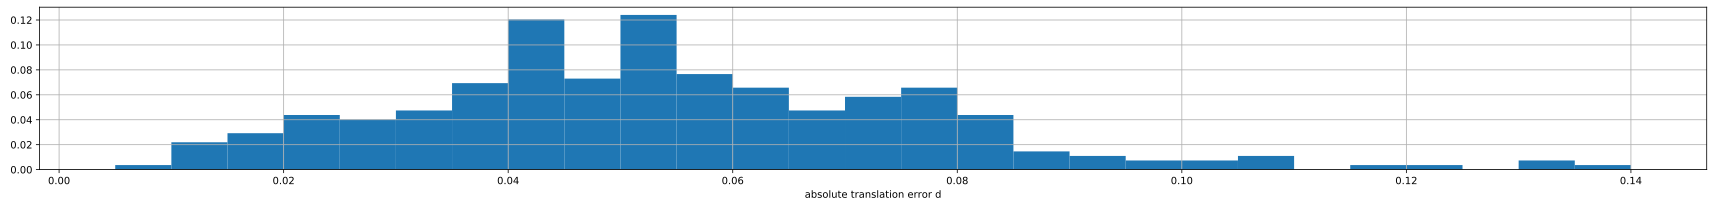

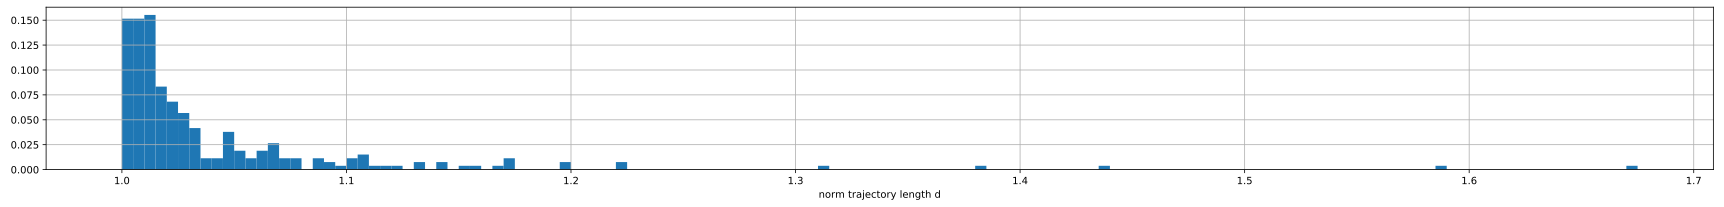

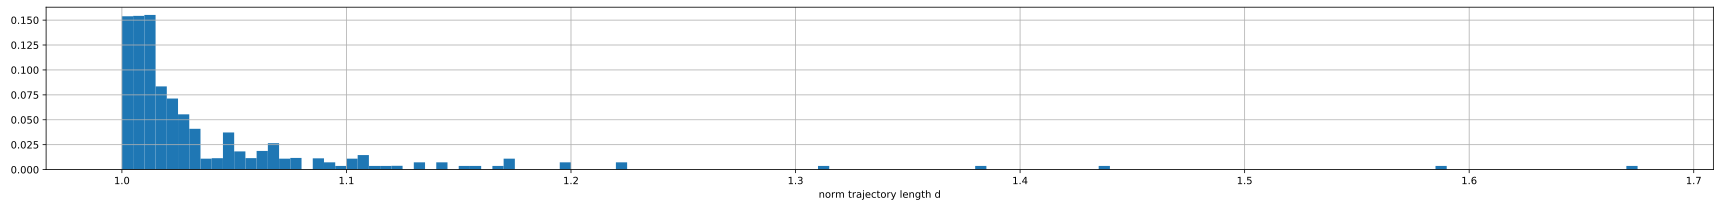

In [6]:
# discretize features

class QuantFeature:
    def __init__(self, name, discrete, quant_w=None):
        self.name = name
        self.quant_w = quant_w
        self.discrete = discrete

quants = [
    QuantFeature('amcl_alpha_factor', discrete=True),
    QuantFeature('beta_1', discrete=True),
    QuantFeature('absolute_translation_error', discrete=False, quant_w=0.005),
    QuantFeature('absolute_rotation_error', discrete=False, quant_w=0.001),
    QuantFeature('normalized_relative_translation_error', discrete=False, quant_w=0.005),
    QuantFeature('normalized_relative_rotation_error', discrete=False, quant_w=0.005),
    QuantFeature('collisionless_success_rate', discrete=True),
    QuantFeature('collision_rate', discrete=True),
    QuantFeature('norm_trajectory_length', discrete=False, quant_w=0.005),
    QuantFeature('norm_execution_time', discrete=False, quant_w=0.005),
    QuantFeature('average_translation_velocity', discrete=False, quant_w=0.005),
    QuantFeature('average_velocity_atan', discrete=False, quant_w=0.05),
]

bin_widths_dict = {
    'amcl_alpha_factor': None,
    'beta_1': None,
    'absolute_translation_error': 0.005,
    'absolute_rotation_error': 0.001,
    'normalized_relative_translation_error': 0.005,
    'normalized_relative_rotation_error': 0.005,
    'collisionless_success_rate': None,
    'collision_rate': None,
    'norm_trajectory_length': 0.005,
    'norm_execution_time': 0.005,
    'average_translation_velocity': 0.005,
    'average_velocity_atan': 0.05,
}

bins_dict = dict()
for feature_name, bin_width in bin_widths_dict.items():
    if bin_width is not None:
        bins = np.arange(0, df[feature_name].max() + bin_width, bin_width)
        bins_dict[feature_name] = bins
        df[f'{feature_name}_d'] = pd.cut(df[feature_name], bins, right=False, labels=bins[:-1]).astype('float')
    else:
        df[f'{feature_name}_d'] = df[feature_name]
        bins_dict[feature_name] = sorted(df[feature_name].unique())

def hist_out(d_output, output_name):

    output_name_d = f"{output_name}_d"
    output = d_output[output_name]
    output_d = d_output[output_name_d]
    
    h = df_to_distribution(output_name=output_name, d=d_output)

    print(f"{output_name_d:<50} min: {output_d.min():.5f} mean: {output_d.mean():.5f} max: {output_d.max():.5f} std: {output_d.std():.5f} count: {output_d.count()}")
    print(f"{output_name:<50} min: {output.min():.5f} mean: {output.mean():.5f} max: {output.max():.5f} std: {output.std():.5f} count: {output_d.count()}")
    print(f"nans: {d_output[output_name].isna().sum()}")
    print()

    fig = plt.figure()
    w = np.abs(h.index[1] - h.index[0]) if len(h.index) > 1 else 1
    hist = plt.bar(h.index + w/2, h, w, fill=True)
    plt.xlabel(output_name_d.replace('_', ' '))
    plt.grid()
    fig.set_size_inches([30, 3])
    plt.show()

def df_to_distribution(output_name, d):

    output_name_d = f"{output_name}_d"
#     output = d[output_name]
#     output_d = d[output_name_d]
    
    # d[output_name_d].notna() is a bool series
    # d[output_name_d].notna().sum() is the count of non-NaN values
    return d.groupby(output_name_d)[output_name_d].count() / d[output_name_d].notna().sum()

def distribution_to_distribution(output_name, input_name, input_distribution, d):
    output_name_d = f"{output_name}_d"
    input_name_d = f"{input_name}_d"

    if input_distribution.sum() < 0.9999:
        print("input_distribution sum < 0.9999")

    output_dist = pd.Series()
    for index_i, p_i in zip(input_distribution.index, input_distribution):
        d_i = d[d[input_name_d] == index_i]
        dist_i = df_to_distribution(output_name=output_name, d=d_i)
        output_dist = output_dist.add(dist_i*p_i, fill_value=0)
    
    if output_dist.sum() < 0.9999:
        print("output_dist sum < 0.9999")

    return output_dist

def plot_distribution(distribution, output_name):
    output_name_d = f"{output_name}_d"
    
    fig = plt.figure()
    w = np.abs(distribution.index[1] - distribution.index[0]) if len(distribution.index) > 1 else 1
    hist = plt.bar(distribution.index + w/2, distribution, w, fill=True)
    plt.xlabel(output_name_d.replace('_', ' '))
    plt.grid()
    fig.set_size_inches([30, 3])
    plt.show()

d_all = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.amcl_alpha_factor_d == 1.0) & (df.beta_1_d == 0.02)].copy()
output_name_l = 'absolute_translation_error'
dist_l = df_to_distribution(output_name=output_name_l, d=d_all)
# print(dist)
plot_distribution(output_name=output_name_l, distribution=dist_l)

d_success = df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.amcl_alpha_factor_d == 1.0) & (df.beta_1_d == 0.02)].copy()
output_name_lp = 'norm_trajectory_length'
dist_lp = df_to_distribution(output_name=output_name_lp, d=d_success)
# print(dist)
plot_distribution(output_name=output_name_lp, distribution=dist_lp)
dist_lp_d2d = distribution_to_distribution(output_name=output_name_lp, input_name=output_name_l, input_distribution=dist_l, d=d_success)
plot_distribution(output_name=output_name_lp, distribution=dist_lp_d2d)

### in:

num datapoints: 292
amcl_alpha_factor_d                                min: 1.00000 mean: 1.00000 max: 1.00000 std: 0.00000 count: 292
amcl_alpha_factor                                  min: 1.00000 mean: 1.00000 max: 1.00000 std: 0.00000 count: 292
nans: 0



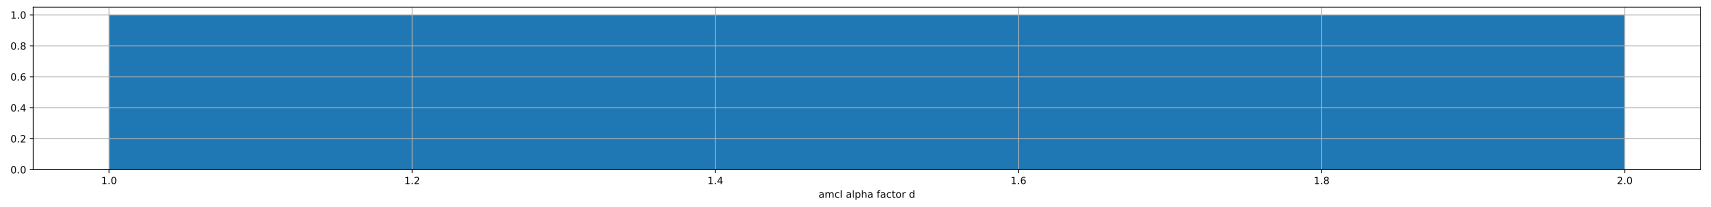

beta_1_d                                           min: 0.02000 mean: 0.02000 max: 0.02000 std: 0.00000 count: 292
beta_1                                             min: 0.02000 mean: 0.02000 max: 0.02000 std: 0.00000 count: 292
nans: 0



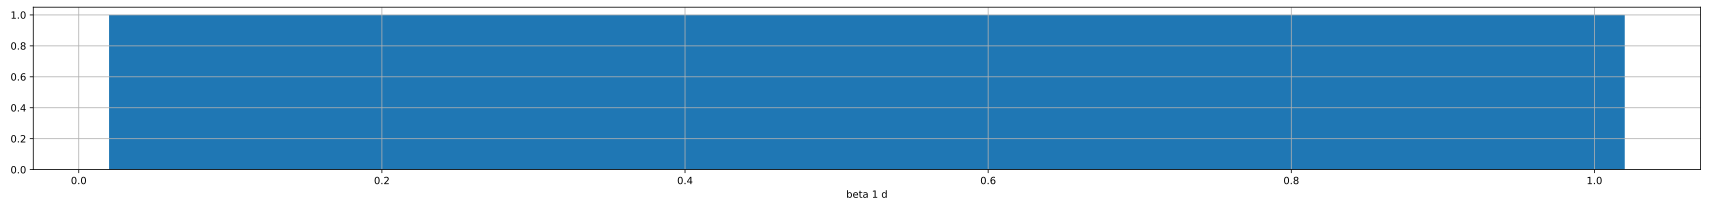

### out localization (all):

num datapoints: 292
absolute_translation_error_d                       min: 0.00500 mean: 0.05157 max: 0.13500 std: 0.02284 count: 274
absolute_translation_error                         min: 0.00924 mean: 0.05397 max: 0.13551 std: 0.02282 count: 274
nans: 18



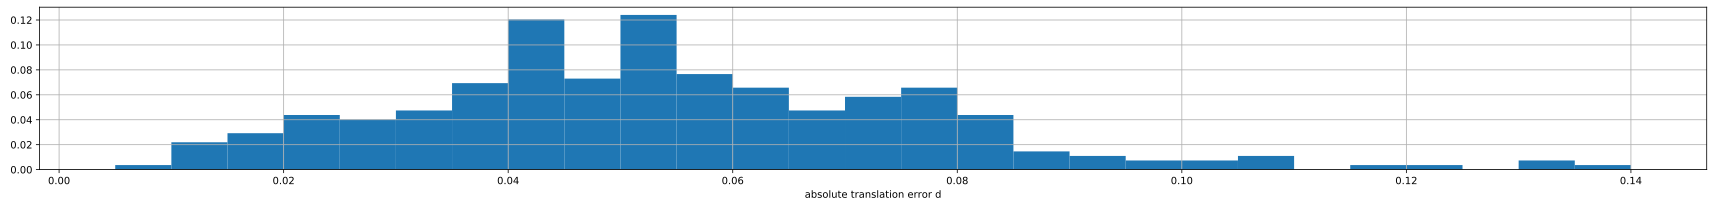

absolute_rotation_error_d                          min: 0.00100 mean: 0.01022 max: 0.09700 std: 0.00995 count: 274
absolute_rotation_error                            min: 0.00172 mean: 0.01073 max: 0.09721 std: 0.00995 count: 274
nans: 18



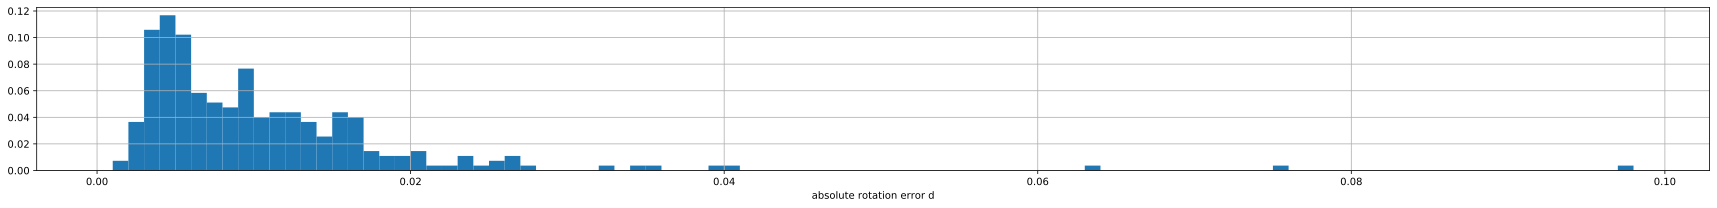

normalized_relative_translation_error_d            min: 0.01000 mean: 0.02881 max: 0.16500 std: 0.01452 count: 274
normalized_relative_translation_error              min: 0.01250 mean: 0.03133 max: 0.16699 std: 0.01449 count: 274
nans: 18



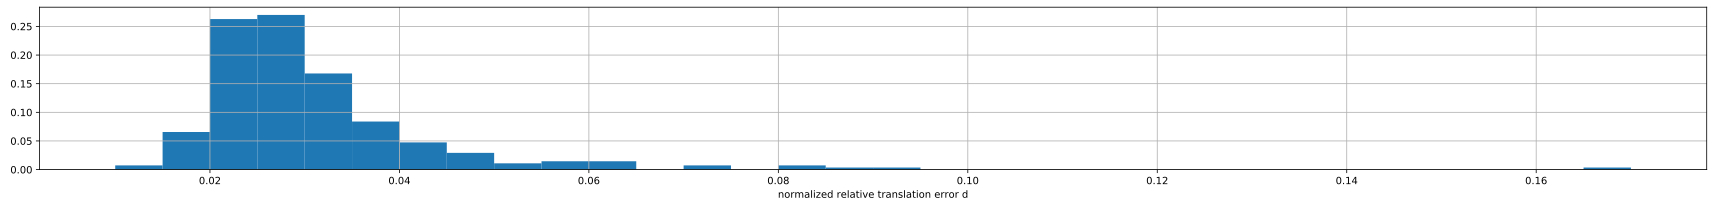

normalized_relative_rotation_error_d               min: 0.00500 mean: 0.15841 max: 6.00500 std: 0.62895 count: 274
normalized_relative_rotation_error                 min: 0.00932 mean: 0.16106 max: 6.00649 std: 0.62883 count: 274
nans: 18



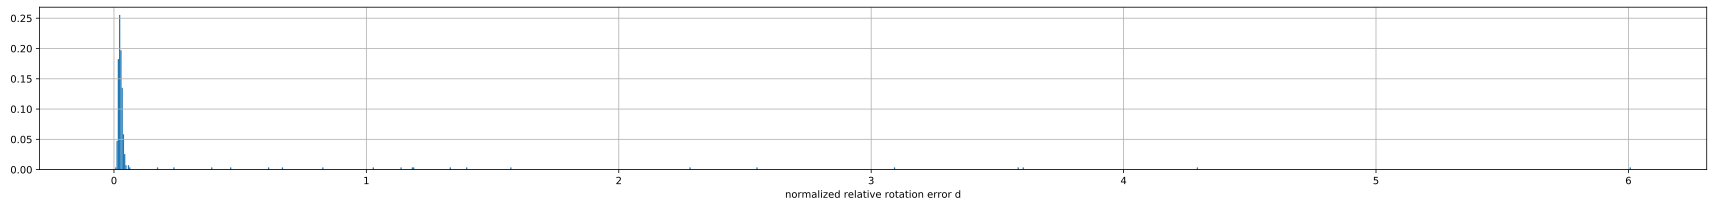

### out local planner (all):

num datapoints: 292
collisionless_success_rate_d                       min: 0.00000 mean: 0.90411 max: 1.00000 std: 0.29495 count: 292
collisionless_success_rate                         min: 0.00000 mean: 0.90411 max: 1.00000 std: 0.29495 count: 292
nans: 0



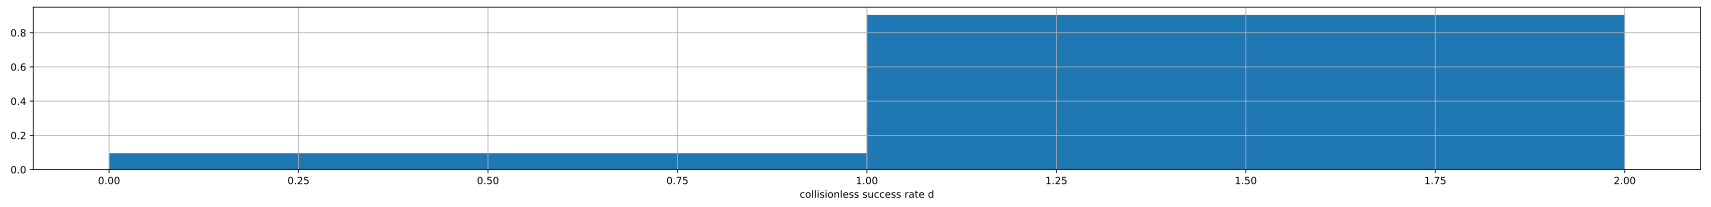

collision_rate_d                                   min: 0.00000 mean: 0.02055 max: 1.00000 std: 0.14211 count: 292
collision_rate                                     min: 0.00000 mean: 0.02055 max: 1.00000 std: 0.14211 count: 292
nans: 0



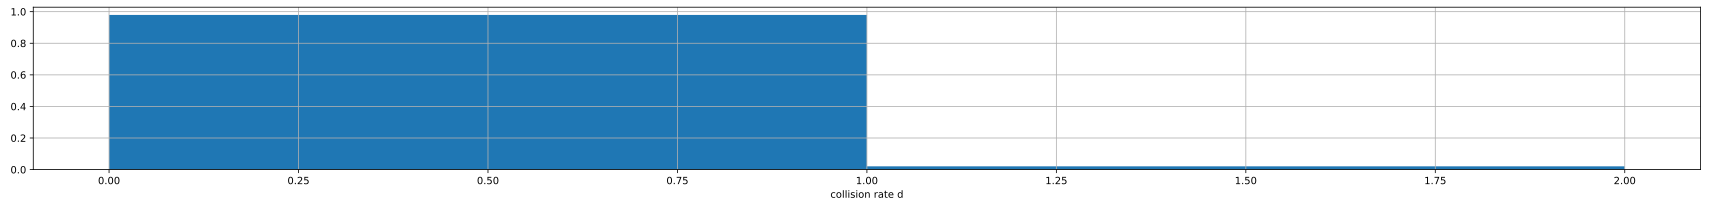

### out local planner (success):

num datapoints: 264
norm_trajectory_length_d                           min: 1.00000 mean: 1.04019 max: 1.67000 std: 0.07621 count: 264
norm_trajectory_length                             min: 1.00000 mean: 1.04277 max: 1.67475 std: 0.07634 count: 264
nans: 0



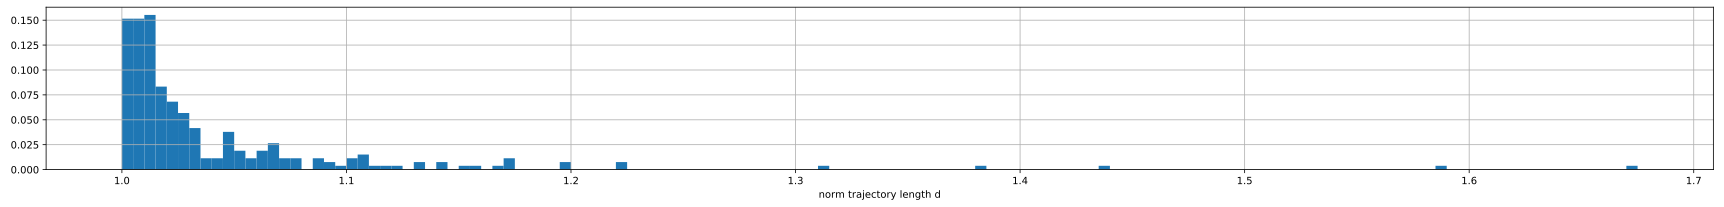

norm_execution_time_d                              min: 1.00000 mean: 1.09322 max: 1.87500 std: 0.12735 count: 264
norm_execution_time                                min: 1.00000 mean: 1.09562 max: 1.87800 std: 0.12744 count: 264
nans: 0



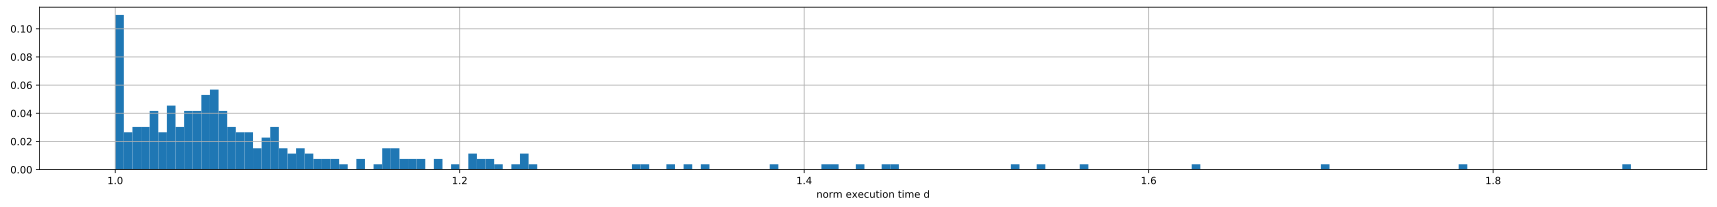

In [7]:

localization_output = [
    'absolute_translation_error',
    'absolute_rotation_error',
    'normalized_relative_translation_error',
    'normalized_relative_rotation_error',
]
local_planner_output_all = [
    'collisionless_success_rate',
    'collision_rate',
]
local_planner_output_success = [
    'norm_trajectory_length',
    'norm_execution_time',
]

amcl_alpha_factor = 1.0
beta_1 = 0.02

printmd("### in:")
d_all = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (d_all.amcl_alpha_factor_d == 1.0) & (d_all.beta_1_d == 0.02)].copy()
print(f"num datapoints: {len(d_all)}")
for input_name in ['amcl_alpha_factor', 'beta_1']:
    hist_out(d_all, input_name)

printmd("### out localization (all):")
d_out_localization_all = d_all
print(f"num datapoints: {len(d_out_localization_all)}")
for output_name in localization_output:
    hist_out(d_out_localization_all, output_name)

printmd("### out local planner (all):")
d_out_local_planner_all = d_all
print(f"num datapoints: {len(d_out_local_planner_all)}")
for output_name in local_planner_output_all:
    hist_out(d_out_local_planner_all, output_name)

d_success = df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (d_success.amcl_alpha_factor_d == 1.0) & (d_success.beta_1_d == 0.02)].copy()
printmd("### out local planner (success):")
d_out_local_planner_success = d_success
print(f"num datapoints: {len(d_out_local_planner_success)}")
for output_name in local_planner_output_success:
    hist_out(d_out_local_planner_success, output_name)


### in:

num datapoints: 2761


### out localization (all):

num datapoints: 292
absolute_translation_error_d                       min: 0.00500 mean: 0.05157 max: 0.13500 std: 0.02284 count: 274
absolute_translation_error                         min: 0.00924 mean: 0.05397 max: 0.13551 std: 0.02282 count: 274
nans: 18



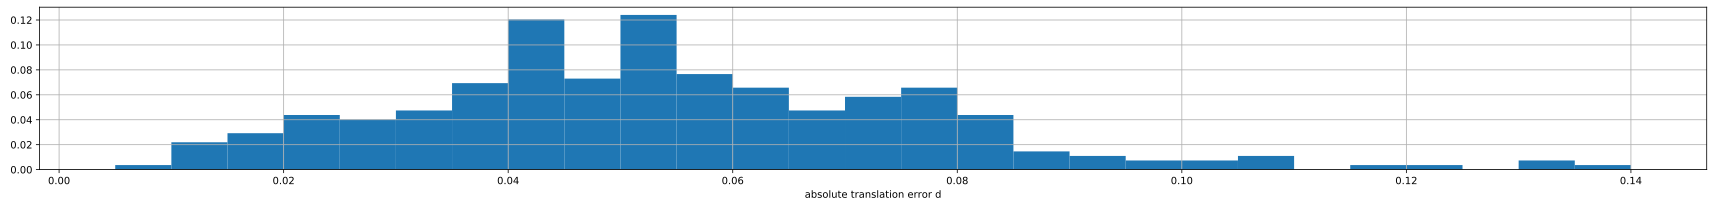

absolute_rotation_error_d                          min: 0.00100 mean: 0.01022 max: 0.09700 std: 0.00995 count: 274
absolute_rotation_error                            min: 0.00172 mean: 0.01073 max: 0.09721 std: 0.00995 count: 274
nans: 18



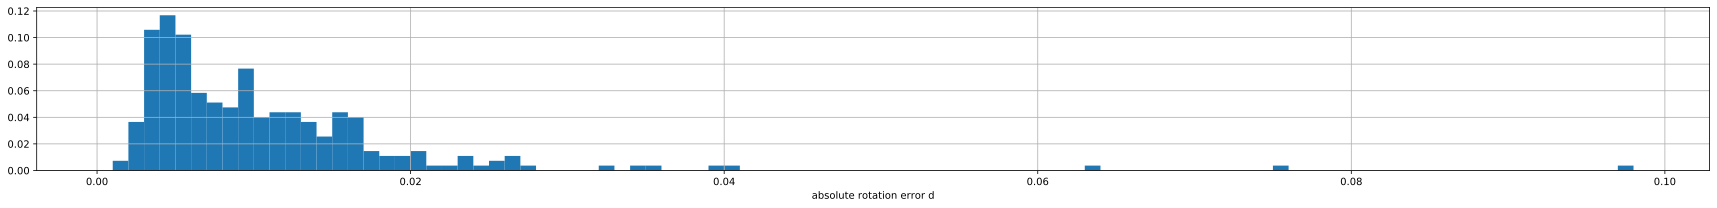

normalized_relative_translation_error_d            min: 0.01000 mean: 0.02881 max: 0.16500 std: 0.01452 count: 274
normalized_relative_translation_error              min: 0.01250 mean: 0.03133 max: 0.16699 std: 0.01449 count: 274
nans: 18



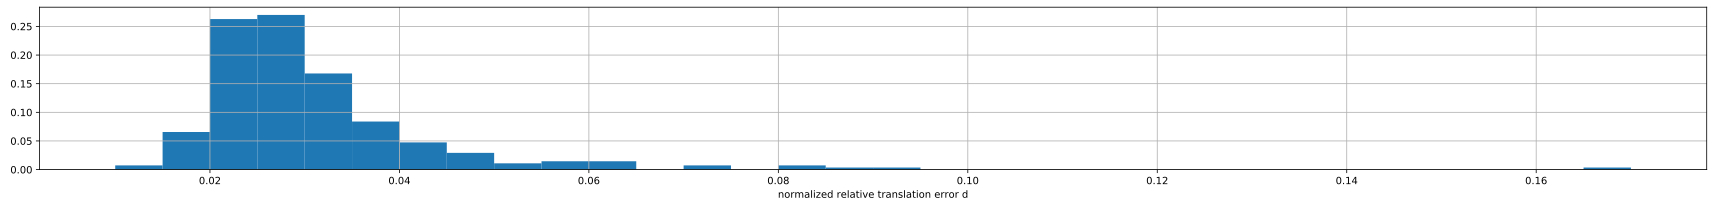

normalized_relative_rotation_error_d               min: 0.00500 mean: 0.15841 max: 6.00500 std: 0.62895 count: 274
normalized_relative_rotation_error                 min: 0.00932 mean: 0.16106 max: 6.00649 std: 0.62883 count: 274
nans: 18



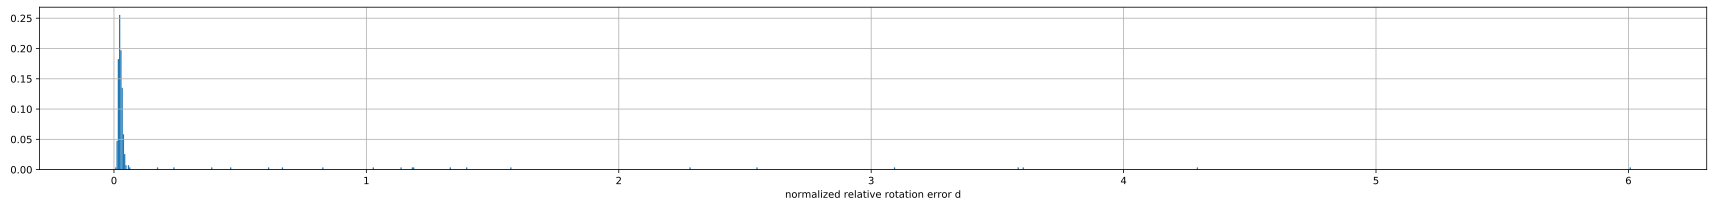

### out local planner (all):

num datapoints: 292
collisionless_success_rate_d                       min: 0.00000 mean: 0.90411 max: 1.00000 std: 0.29495 count: 292
collisionless_success_rate                         min: 0.00000 mean: 0.90411 max: 1.00000 std: 0.29495 count: 292
nans: 0



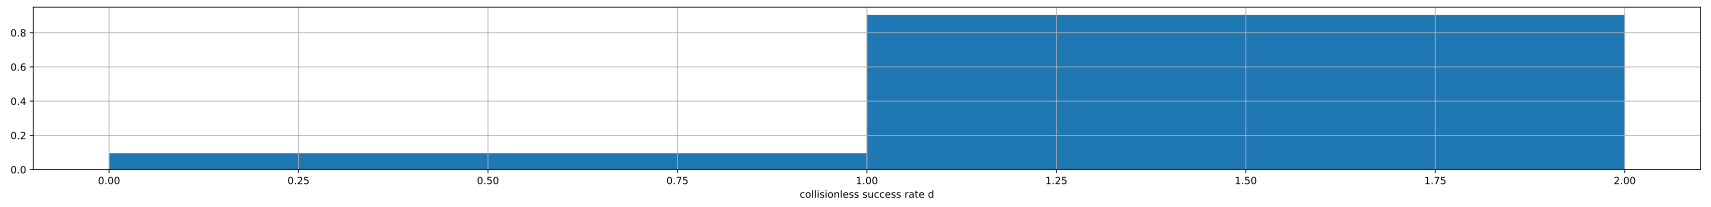

collision_rate_d                                   min: 0.00000 mean: 0.02055 max: 1.00000 std: 0.14211 count: 292
collision_rate                                     min: 0.00000 mean: 0.02055 max: 1.00000 std: 0.14211 count: 292
nans: 0



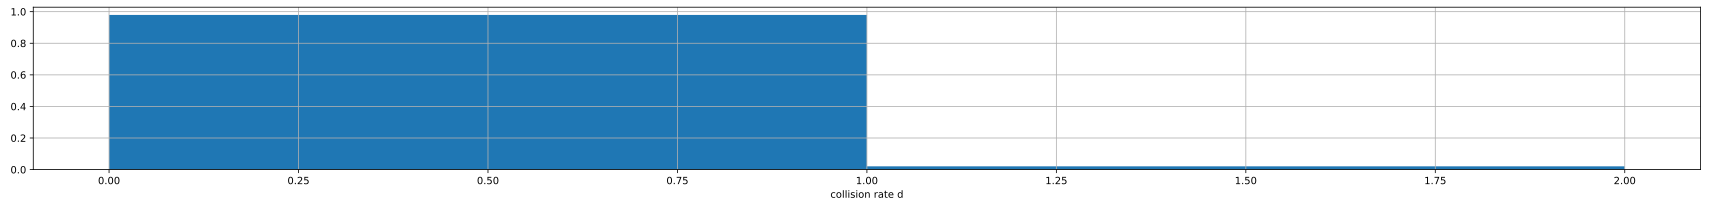

### out local planner (success):

num datapoints: 264
norm_trajectory_length_d                           min: 1.00000 mean: 1.04019 max: 1.67000 std: 0.07621 count: 264
norm_trajectory_length                             min: 1.00000 mean: 1.04277 max: 1.67475 std: 0.07634 count: 264
nans: 0



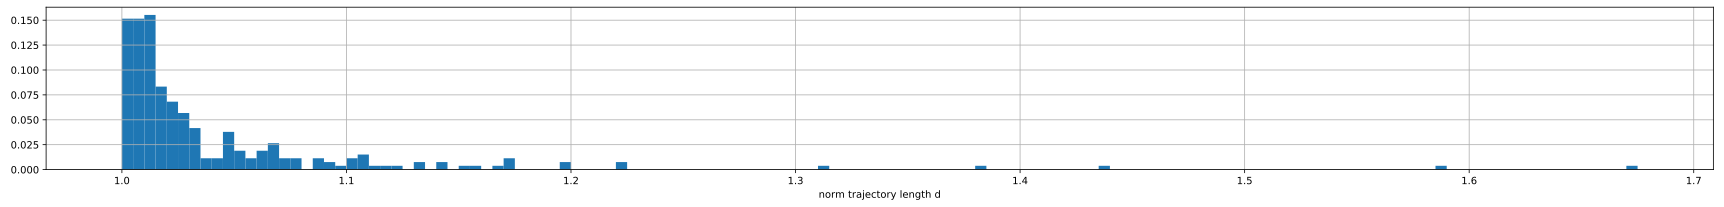

norm_execution_time_d                              min: 1.00000 mean: 1.09322 max: 1.87500 std: 0.12735 count: 264
norm_execution_time                                min: 1.00000 mean: 1.09562 max: 1.87800 std: 0.12744 count: 264
nans: 0



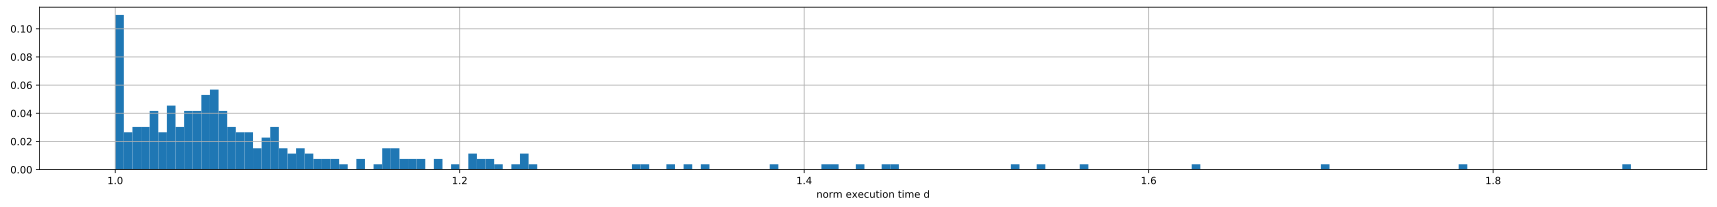

In [8]:

localization_output = [
    'absolute_translation_error',
    'absolute_rotation_error',
    'normalized_relative_translation_error',
    'normalized_relative_rotation_error',
]
local_planner_output_all = [
    'collisionless_success_rate',
    'collision_rate',
]
local_planner_output_success = [
    'norm_trajectory_length',
    'norm_execution_time',
]

amcl_alpha_factor = 1.0
beta_1 = 0.02

printmd("### in:")
d_all = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
print(f"num datapoints: {len(d_all)}")

printmd("### out localization (all):")
d_out_localization_all = d_all[(d_all.amcl_alpha_factor_d == 1.0) & (d_all.beta_1_d == 0.02)]
print(f"num datapoints: {len(d_out_localization_all)}")
for output_name in localization_output:
    hist_out(d_out_localization_all, output_name)

printmd("### out local planner (all):")
d_out_local_planner_all = d_all[(d_all.amcl_alpha_factor_d == 1.0) & (d_all.beta_1_d == 0.02)]
print(f"num datapoints: {len(d_out_local_planner_all)}")
for output_name in local_planner_output_all:
    hist_out(d_out_local_planner_all, output_name)

d_success = df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
printmd("### out local planner (success):")
d_out_local_planner_success = d_success[(d_success.amcl_alpha_factor_d == 1.0) & (d_success.beta_1_d == 0.02)]
print(f"num datapoints: {len(d_out_local_planner_success)}")
for output_name in local_planner_output_success:
    hist_out(d_out_local_planner_success, output_name)
